In [ ]:
# L4
import os
os.environ["KAGGLE_CONFIG_DIR"] = '/content'
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip /content/chest-xray-pneumonia.zip &> /dev/null

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:33<00:00, 34.3MB/s]
100% 2.29G/2.29G [01:33<00:00, 26.4MB/s]


In [ ]:
!pip install tqdm==4.40.0 &> /dev/null
!pip install ttach &> /dev/null

In [ ]:
!git clone https://github.com/jacobgil/pytorch-grad-cam.git &> /dev/null

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models, utils
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import numpy as np
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
# Preparing the Datasets

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
trianDataset = datasets.ImageFolder("/content/chest_xray/train", transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((384,384)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop(
      size=(384, 384),
      scale=(0.87, 1.15),
      ratio=(0.7, 1.3)),
    transforms.RandomRotation(degrees=(-180, 180)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    normalize,
]))
testDataset = datasets.ImageFolder("/content/chest_xray/test", transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((384,384)),
    normalize,
]))

In [ ]:
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Resize((384,384)),
    normalize,
])

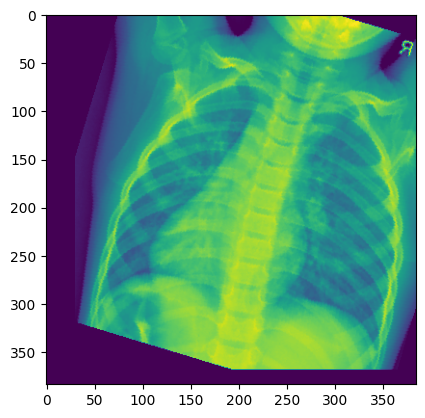

In [ ]:
# Testing the train dataset

plt.imshow(trianDataset[0][0][0,:,:])

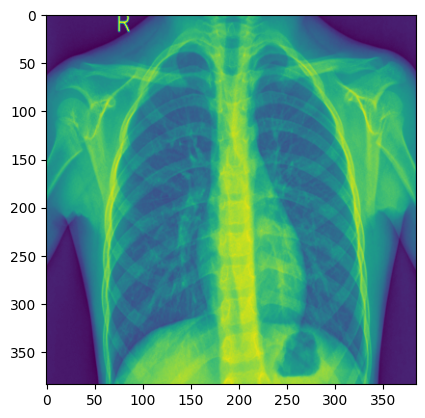

In [ ]:
# Testing the test dataset

plt.imshow(testDataset[0][0][0,:,:])

In [ ]:
# Putting the datasets in dataloaders

trainLoader = DataLoader(trianDataset, batch_size=512, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=512, shuffle=False)

In [ ]:
# Testing the dataloaders

print(len(trainLoader))
print(len(testLoader))
batch = next(iter(trainLoader))
batch[1].shape

11
2


torch.Size([512])

# Importing and Training the Model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
model = models.inception_v3(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|████████████████████████████████████████████████████████████| 104M/104M [00:00<00:00, 210MB/s]


In [ ]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# Freezing all layers except the last layer

for parameter in model.parameters():
    parameter.requires_grad = False

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.fc = nn.Linear(2048, 2).to(device)
model.aux_logits = False
model.AuxLogits = None

In [ ]:
"""
Contains functions for training and testing a PyTorch model.
"""

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
# Create optimizer and loss function

optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=1e-3, weight_decay=0)
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.945, 0.673])).to(device)

In [ ]:
# Train the model

pretrained_vit_results = train(model=model,
                                      train_dataloader=trainLoader,
                                      test_dataloader=testLoader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 1 | train_loss: 0.6802 | train_acc: 0.5521 | test_loss: 0.6676 | test_acc: 0.6275
Epoch: 2 | train_loss: 0.5787 | train_acc: 0.7595 | test_loss: 0.6530 | test_acc: 0.5911
Epoch: 3 | train_loss: 0.5226 | train_acc: 0.7766 | test_loss: 0.6206 | test_acc: 0.6705
Epoch: 4 | train_loss: 0.4768 | train_acc: 0.8102 | test_loss: 0.5797 | test_acc: 0.7268
Epoch: 5 | train_loss: 0.4473 | train_acc: 0.8229 | test_loss: 0.5069 | test_acc: 0.8111
Epoch: 6 | train_loss: 0.4231 | train_acc: 0.8362 | test_loss: 0.5155 | test_acc: 0.7637
Epoch: 7 | train_loss: 0.3994 | train_acc: 0.8414 | test_loss: 0.5079 | test_acc: 0.7538
Epoch: 8 | train_loss: 0.4004 | train_acc: 0.8313 | test_loss: 0.4721 | test_acc: 0.8057
Epoch: 9 | train_loss: 0.3862 | train_acc: 0.8423 | test_loss: 0.4484 | test_acc: 0.8472
Epoch: 10 | train_loss: 0.3694 | train_acc: 0.8517 | test_loss: 0.4421 | test_acc: 0.8482



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model,"/content/drive/MyDrive/Trained_Models/InceptionV3_Pneumonia.pt")

In [ ]:
model = torch.load("/content/drive/MyDrive/Trained_Models/InceptionV3_Pneumonia.pt").to(device)

# Evaluating the Model

In [ ]:
y_pred = []
y_true = []
model.eval()
with torch.no_grad():
    for batch in testLoader:
        inputs, _ = batch  # Assuming your dataset returns (input, label)
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted_classes = outputs.max(1)  # Get the index of the predicted class
        y_pred.extend(predicted_classes.tolist())
        y_true.extend(batch[1].tolist())

print(f"All predictions: {y_pred}")

All predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       234
           1       0.88      0.84      0.86       390

    accuracy                           0.83       624
   macro avg       0.81      0.82      0.82       624
weighted avg       0.83      0.83      0.83       624

kappa_score =  0.6333052985702271


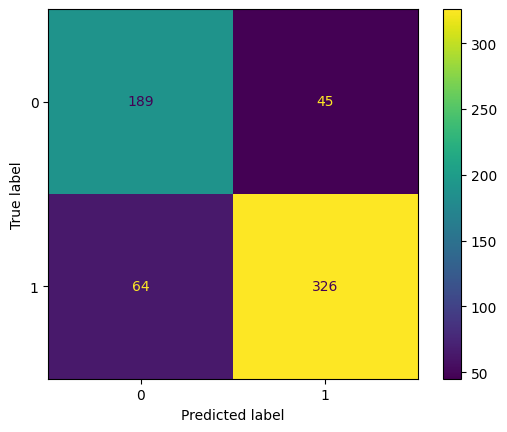

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, cohen_kappa_score

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()
print(classification_report(y_true, y_pred, target_names=["0","1"]))
print("kappa_score = ", cohen_kappa_score(y_true, y_pred))

# Showing The Model's Feature Maps

In [ ]:
# we will save the conv layer weights in this list
model_weights = []
#we will save the 49 conv layers in this list
conv_layers = []
for module in model.modules():
  if isinstance(module, nn.Conv2d):
    conv_layers.append(module)
    model_weights.append(module.weight)
print(f"Total convolution layers: {len(conv_layers)}")
print(conv_layers)

Total convolution layers: 94
[Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False), Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False), Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False), Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(192, 48, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False), Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(256, 48, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(48, 64, ker

In [ ]:
image = Image.open("/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg")
image = test_transform(image).to(device)
image.shape

torch.Size([3, 384, 384])

In [ ]:
# Generate Feature maps

outputs = []
names = []
counter = 0
for layer in conv_layers[0:]:
    print(counter)
    counter += 1
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

# TO DO: A problem in propgating the image. Reveiw InceptionV3 implementation.

In [ ]:
# Convert 3D tensor to 2D, Sum the same element of every channel

processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(191, 191)
(189, 189)
(189, 189)
(189, 189)
(187, 187)
(187, 187)


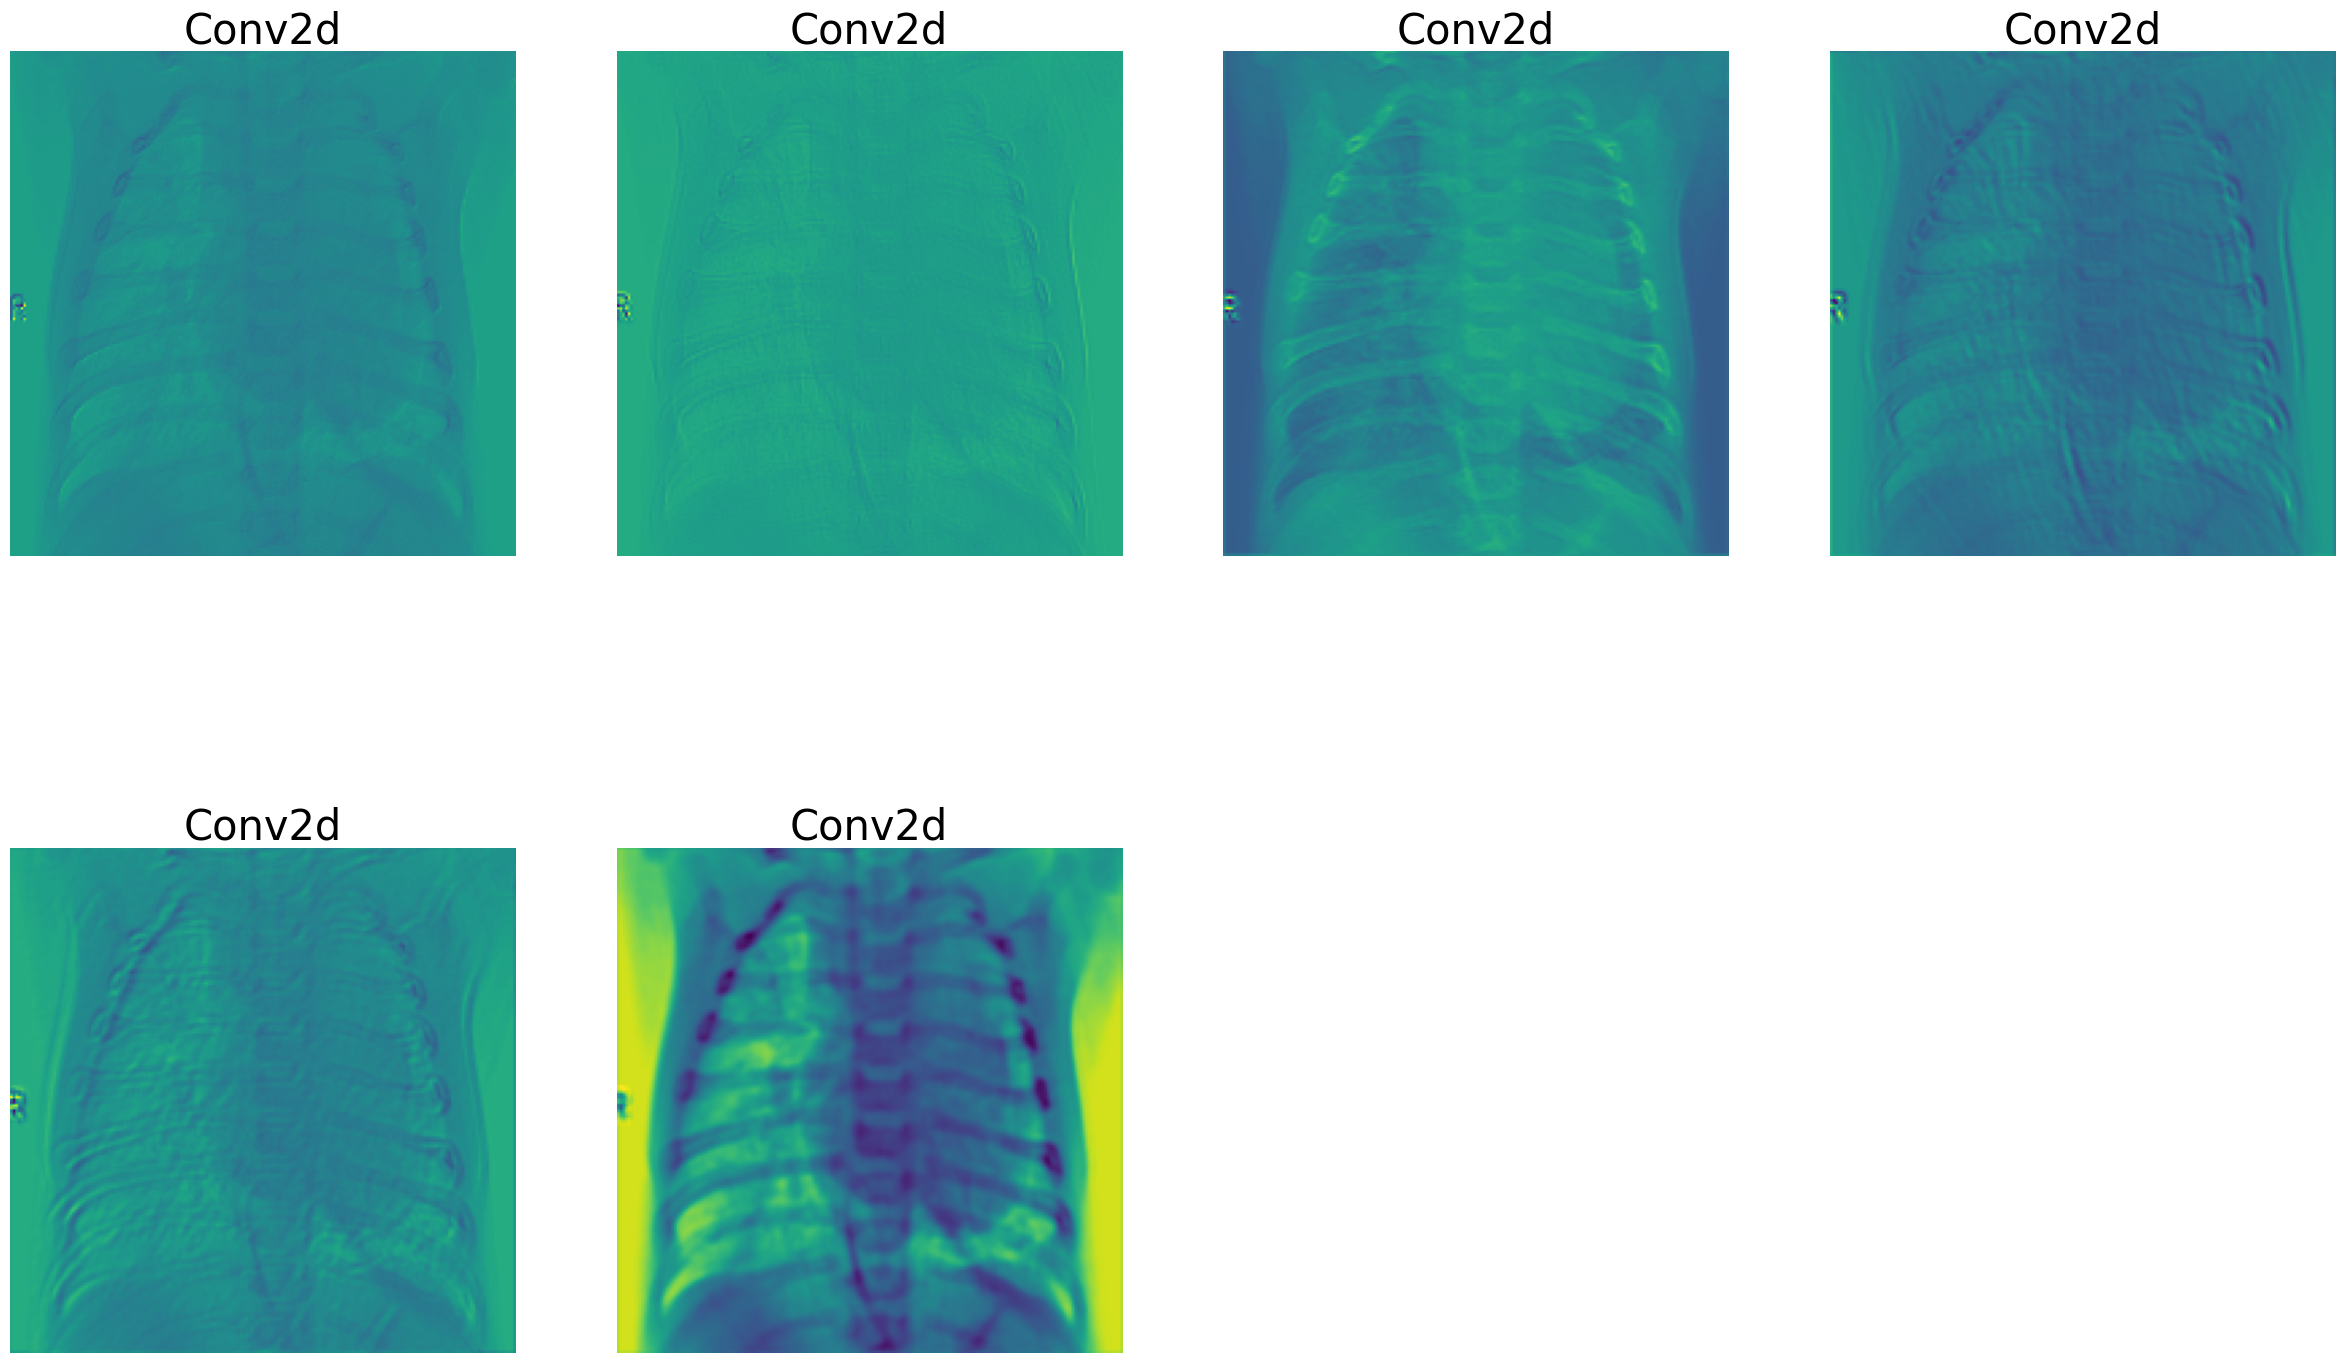

In [ ]:
# Plotting feature maps and save

fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

# Visualizing the Areas of Interest in the Image Using Grad-CAM

In [ ]:
# Making sure that the gradient for all the parameters can be calculated

for parameter in model.parameters():
    parameter.requires_grad = True

In [ ]:
# Taking the layers we want to include and preparing the input and real images

target_layers = [model._modules.get('Mixed_7c')]
# Taking the layers we want to include and preparing the input and real images
img = np.array(Image.open("/content/chest_xray/test/PNEUMONIA/person111_bacteria_533.jpeg").resize((384, 384)))/255.0
img = np.stack((img,)*3, axis=-1)
input_tensor = test_transform(Image.open("/content/chest_xray/test/PNEUMONIA/person111_bacteria_533.jpeg")).unsqueeze(0)

In [ ]:
# Visualizing the Grad-CAM of the image

model.eval()
cam = GradCAM(model=model, target_layers=target_layers)
# targets = [ClassifierOutputTarget(1)]
grayscale_cam = cam(input_tensor=input_tensor, targets=None)
grayscale_cam = grayscale_cam[0, :]
grayscale_cam = Image.fromarray(grayscale_cam)
grayscale_cam = np.array(grayscale_cam)
visualization = show_cam_on_image(np.array(img), grayscale_cam, use_rgb=True)
model_outputs = cam.outputs

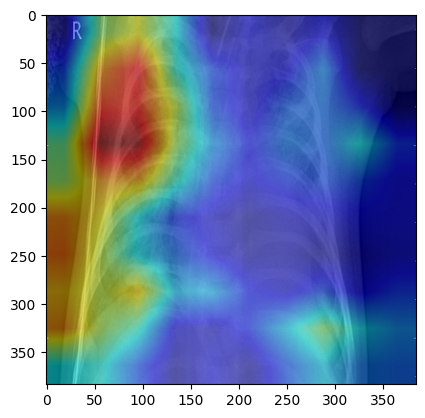

In [ ]:
plt.imshow(visualization)

# An example for using anyother visualization technique.

In [ ]:
# img = np.array(Image.open("/content/test_images/01499815e469.png").resize((384, 384)))/255.0
# input_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)
# input_tensor = input_tensor.float()

In [ ]:
# model.eval()
# cam = GradCAMPlusPlus(model=model, target_layers=target_layers)
# # targets = [ClassifierOutputTarget(1)]
# grayscale_cam = cam(input_tensor=input_tensor, targets=None)
# grayscale_cam = grayscale_cam[0, :]
# grayscale_cam = Image.fromarray(grayscale_cam)
# grayscale_cam = np.array(grayscale_cam)
# visualization = show_cam_on_image(np.array(img), grayscale_cam, use_rgb=True)
# model_outputs = cam.outputs